## PLACO
**Steps:**
1. Construct merged dataframe and save to csv
2. Run PLACO
3. Add `CHR`, `SNP`, `BP` to PLACO results

## Step 1: Construct merged dataframe and save to csv

In [1]:
import pandas as pd
import numpy as np

# Load union SNPs
union_lead_snps = pd.read_csv("../4_LD_clumping/union_lead_snps.csv")
snp_list = union_lead_snps["SNP"].tolist()

# Load datasets
df1 = pd.read_csv("../1_CAD/CAD_clean.csv")
df2 = pd.read_csv("../2_MDD/MDD_clean.csv")

# Subset df1 and df2 to only include SNPs in the union list
df1_subset = df1[df1["SNP"].isin(snp_list)].copy()
df2_subset = df2[df2["SNP"].isin(snp_list)].copy()

print(f"Length of CAD SNPs: {len(df1_subset)}")
print(f"Length of MDD SNPs: {len(df2_subset)}")

df1_subset.reset_index(drop=True, inplace=True)
df2_subset.reset_index(drop=True, inplace=True)

# Save to CSV files
df1_subset.to_csv("CAD_clumped_subset.csv", index=False)
df2_subset.to_csv("MDD_clumped_subset.csv", index=False)

Length of CAD SNPs: 396
Length of MDD SNPs: 396


In [2]:
import pandas as pd

# Ensure SNPs are aligned (i.e., both dataframes have the same SNPs and same order)
df1_subset = df1_subset.sort_values("SNP").reset_index(drop=True)
df2_subset = df2_subset.sort_values("SNP").reset_index(drop=True)

# Sanity check: ensure SNPs are the same and aligned
assert all(df1_subset["SNP"] == df2_subset["SNP"]), "SNPs are not aligned!"

# Identify swapped alleles (i.e., A1 in df1 matches A2 in df2 and vice versa)
swapped = (df1_subset["A1"] == df2_subset["A2"]) & (df1_subset["A2"] == df2_subset["A1"])

# Flip β in df2_subset where alleles are swapped
df2_subset.loc[swapped, "BETA"] = -df2_subset.loc[swapped, "BETA"]

# (Optional) Flip odds ratio (OR = exp(BETA))
df2_subset.loc[swapped, "OR"] = 1 / df2_subset.loc[swapped, "OR"]

# Also swap alleles in df2_subset to match df1_subset
df2_subset.loc[swapped, ["A1", "A2"]] = df2_subset.loc[swapped, ["A2", "A1"]].values

# Verify harmonization
assert all(df1_subset["A1"] == df2_subset["A1"]), "A1 alleles not fully harmonized."


In [3]:
df1_subset["Z"] = df1_subset["BETA"] / df1_subset["SE_BETA"]
df2_subset["Z"] = df2_subset["BETA"] / df2_subset["SE_BETA"]

In [4]:
df1_subset.head()

,CHR,SNP,BP,A1,A2,OR,BETA,SE_BETA,P,Z,MAF
0,5,rs10060069,20143940,A,G,0.985539,-0.014567,0.009513,1.256835e-01,-1.531353,0.528919
1,2,rs10171924,10201514,G,A,1.004110,0.004102,0.011845,7.291075e-01,0.346312,0.781197
2,2,rs10174652,204427340,A,G,0.923960,-0.079086,0.014475,4.660000e-08,-5.463740,0.880781
3,7,rs1020004,12255778,T,C,0.984693,-0.015425,0.009781,1.147813e-01,-1.577069,0.674259
4,7,rs10255943,114072443,G,A,1.025595,0.025273,0.011102,2.281700e-02,2.276478,0.717309


In [5]:
df2_subset.head()

,CHR,SNP,BP,A1,A2,OR,BETA,SE_BETA,P,Z,MAF
0,5,rs10060069,20143940,A,G,0.978435,-0.021801,0.0043,5.583000e-07,-5.069914,0.466022
1,2,rs10171924,10201514,G,A,0.973852,-0.026496,0.0055,1.242000e-06,-4.817430,0.165171
2,2,rs10174652,204427340,A,G,1.006820,0.006797,0.0066,3.087000e-01,1.029826,0.885505
3,7,rs1020004,12255778,T,C,0.979410,-0.020805,0.0047,9.294000e-06,-4.426581,0.715807
4,7,rs10255943,114072443,G,A,1.024286,0.023996,0.0048,4.784000e-07,4.999084,0.269978


In [6]:
# --- Merge CAD and MDD datasets on SNP, CHR, BP ---
merged = pd.merge(df1_subset, df2_subset, on=["SNP", "CHR", "BP"], suffixes=("_cad", "_mdd"))

# --- Construct Z matrix ---
Z_matrix = merged[["Z_cad", "Z_mdd"]].to_numpy()
Z_matrix_df = pd.DataFrame(Z_matrix, index=merged["SNP"], columns=["Z_cad", "Z_mdd"])

# --- Construct P matrix ---
P_matrix = merged[["P_cad", "P_mdd"]].to_numpy()
P_matrix_df = pd.DataFrame(P_matrix, index=merged["SNP"], columns=["P_cad", "P_mdd"])

# --- Write outputs ---
merged.to_csv("CAD_MDD_merged.csv", index=False)
Z_matrix_df.to_csv("Z_matrix.csv", index=False)
P_matrix_df.to_csv("P_matrix.csv", index=False)

## Step 2: Run PLACO

In [7]:
merged

,CHR,SNP,BP,A1_cad,A2_cad,OR_cad,BETA_cad,SE_BETA_cad,P_cad,Z_cad,MAF_cad,A1_mdd,A2_mdd,OR_mdd,BETA_mdd,SE_BETA_mdd,P_mdd,Z_mdd,MAF_mdd
0,5,rs10060069,20143940,A,G,0.985539,-0.014567,0.009513,1.256835e-01,-1.531353,0.528919,A,G,0.978435,-0.021801,0.0043,5.583000e-07,-5.069914,0.466022
1,2,rs10171924,10201514,G,A,1.004110,0.004102,0.011845,7.291075e-01,0.346312,0.781197,G,A,0.973852,-0.026496,0.0055,1.242000e-06,-4.817430,0.165171
2,2,rs10174652,204427340,A,G,0.923960,-0.079086,0.014475,4.660000e-08,-5.463740,0.880781,A,G,1.006820,0.006797,0.0066,3.087000e-01,1.029826,0.885505
3,7,rs1020004,12255778,T,C,0.984693,-0.015425,0.009781,1.147813e-01,-1.577069,0.674259,T,C,0.979410,-0.020805,0.0047,9.294000e-06,-4.426581,0.715807
4,7,rs10255943,114072443,G,A,1.025595,0.025273,0.011102,2.281700e-02,2.276478,0.717309,G,A,1.024286,0.023996,0.0048,4.784000e-07,4.999084,0.269978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,16,rs9938059,49097277,C,T,1.002053,0.002051,0.011163,8.542185e-01,0.183739,0.748151,C,T,0.976580,-0.023699,0.0052,4.400000e-06,-4.557424,0.751473
392,14,rs9944047,97226823,T,C,1.014632,0.014526,0.009808,1.385972e-01,1.481036,0.586284,T,C,1.022450,0.022202,0.0043,1.857000e-07,5.163188,0.532753
393,18,rs9964724,35159124,T,C,1.014243,0.014143,0.009765,1.475046e-01,1.448395,0.654660,T,C,0.973748,-0.026603,0.0045,3.768000e-09,-5.911774,0.297698
394,1,rs9970807,56965664,C,T,1.133999,0.125750,0.016695,5.000000e-14,7.532195,0.915097,C,T,1.014810,0.014701,0.0071,3.848000e-02,2.070620,0.903236


In [2]:
### Jupyter (BDSY) r_env
## R

## Load in the PLACO library

#if (!requireNamespace("devtools", quietly = TRUE)) {
#  install.packages('devtools')
#}
require(devtools)
source_url("https://github.com/RayDebashree/PLACO/blob/master/PLACO_v0.2.0.R?raw=TRUE")

ℹ SHA-1 hash of file is "bdedd84e020f16971d45f176b2e59b2c2a71fe11"

                  PLACO v0.2.0 is loaded


If you use this software, please cite:



Original PLACO paper -->

Ray and Chatterjee (2020) A powerful method for pleiotropic analysis

    under composite null hypothesis identifies novel shared

    loci between type 2 diabetes and prostate cancer.

    PLoS Genetics 16(12): e1009218



PLACO+ paper -->

Park and Ray (2025+) A robust pleiotropy method with

    applications to lipid traits and to inflammatory bowel

    disease subtypes with sample overlap. Submitted.



**See https://github.com/RayDebashree/PLACO for updated citations

--------------------------------------------------------------------





In [3]:
# Read Z matrix
Z_df <- read.csv("Z_matrix.csv")
Z <- as.matrix(Z_df)

# Read P matrix
P_df <- read.csv("P_matrix.csv")
P <- as.matrix(P_df)

# Run PLACO variance estimation
VarZ <- var.placo(Z, P, p.threshold = 1e-4)

In [8]:
# Step 1: Apply test of pleiotropy for each variant using PLACO+
p <- nrow(Z)
out <- sapply(1:p, function(i) placo(Z=Z[i,], VarZ=VarZ))
# (returns a 2xp matrix of PLACO+ test statistics and p-values for p variants)

out <- t(out)  # Now out is a p × 2 matrix

# Convert to data frame
out_df <- as.data.frame(out)

head(out_df)

,T.placo,p.placo
,<list>,<list>
1,7.76383,0.1230675
2,-1.668335,0.8116968
3,-5.6267,0.2359018
4,6.981025,0.1558003
5,11.3803,0.04268031
6,0.2904788,1.082506


## Step 3: Add `CHR`, `SNP`, `BP` to PLACO results

In [9]:
# Step 1: Read the merged file
merged_df <- read.csv("CAD_MDD_merged.csv", header = TRUE)

# Step 2: Append CHR, SNP, BP to out_df
out_df$CHR <- merged_df$CHR
out_df$SNP <- merged_df$SNP
out_df$BP  <- merged_df$BP

# Step 3: Reorder the columns
out_df <- out_df[, c("CHR", "SNP", "BP", "T.placo", "p.placo")]

In [10]:
head(out_df)

,CHR,SNP,BP,T.placo,p.placo
,<int>,<chr>,<int>,<list>,<list>
1,5,rs10060069,20143940,7.76383,0.1230675
2,2,rs10171924,10201514,-1.668335,0.8116968
3,2,rs10174652,204427340,-5.6267,0.2359018
4,7,rs1020004,12255778,6.981025,0.1558003
5,7,rs10255943,114072443,11.3803,0.04268031
6,7,rs10261234,12096667,0.2904788,1.082506


In [11]:
# Write to csv
# Unlist the list-columns
out_df$T.placo <- unlist(out_df$T.placo)
out_df$p.placo <- unlist(out_df$p.placo)

# Now write to CSV
write.csv(out_df, file = "PLACO_output.csv", row.names = FALSE)


In [9]:
import pandas as pd
df = pd.read_csv("PLACO_output.csv")

In [10]:
df.head()

,CHR,SNP,BP,T.placo,p.placo
0,5,rs10060069,20143940,7.763830,0.123068
1,2,rs10171924,10201514,-1.668335,0.811697
2,2,rs10174652,204427340,-5.626700,0.235902
3,7,rs1020004,12255778,6.981025,0.155800
4,7,rs10255943,114072443,11.380304,0.042680


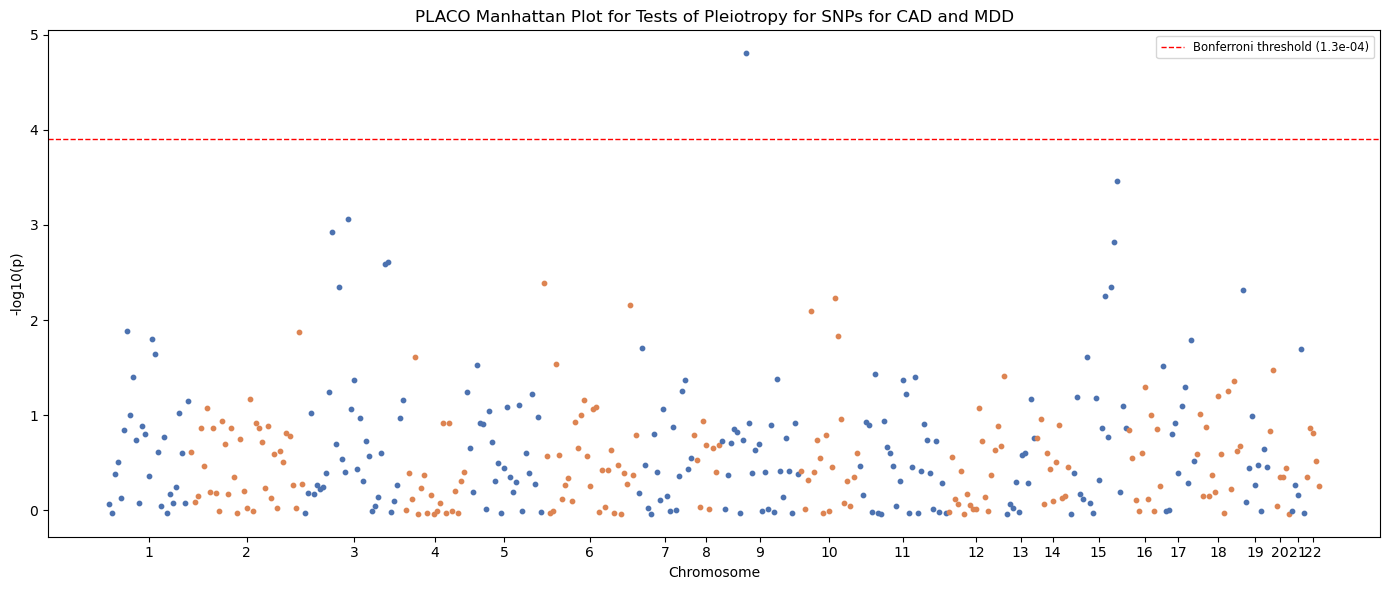

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Read the CSV
df = pd.read_csv("PLACO_output.csv")

# Step 2: Calculate significance level
alpha = 0.05
num_rows = len(df)  # 396
significance_level = alpha / num_rows
threshold_line = -np.log10(significance_level)

# Step 3: Prepare the data
df['-log10(p)'] = -np.log10(df['p.placo'])
df['CHR'] = df['CHR'].astype(str)
df['CHR'] = df['CHR'].astype('category')
df['CHR'] = df['CHR'].cat.set_categories(sorted(df['CHR'].unique(), key=lambda x: int(x)), ordered=True)
df = df.sort_values(['CHR', 'BP'])

# Step 4: Create chromosome-specific index for plotting
df['ind'] = range(len(df))
df_grouped = df.groupby('CHR')

# Step 5: Plot
plt.figure(figsize=(14, 6))
colors = ['#4C72B0', '#DD8452']
x_labels = []
x_labels_pos = []

for i, (chr_name, group) in enumerate(df_grouped):
    plt.scatter(group['ind'], group['-log10(p)'], color=colors[i % 2], s=10, label=None)  # Avoid duplicate legend entries
    x_labels.append(chr_name)
    x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)

# Add genome-wide significance threshold line
plt.axhline(y=threshold_line, color='red', linestyle='--', linewidth=1, label=f'Bonferroni threshold ({significance_level:.1e})')

# Add legend
plt.legend(loc='upper right', fontsize='small')

# Final plot adjustments
plt.xticks(x_labels_pos, x_labels)
plt.xlabel('Chromosome')
plt.ylabel('-log10(p)')
plt.title('PLACO Manhattan Plot for Tests of Pleiotropy for SNPs for CAD and MDD')
plt.savefig("PLACO_manhattan.jpeg")
plt.tight_layout()
plt.show()

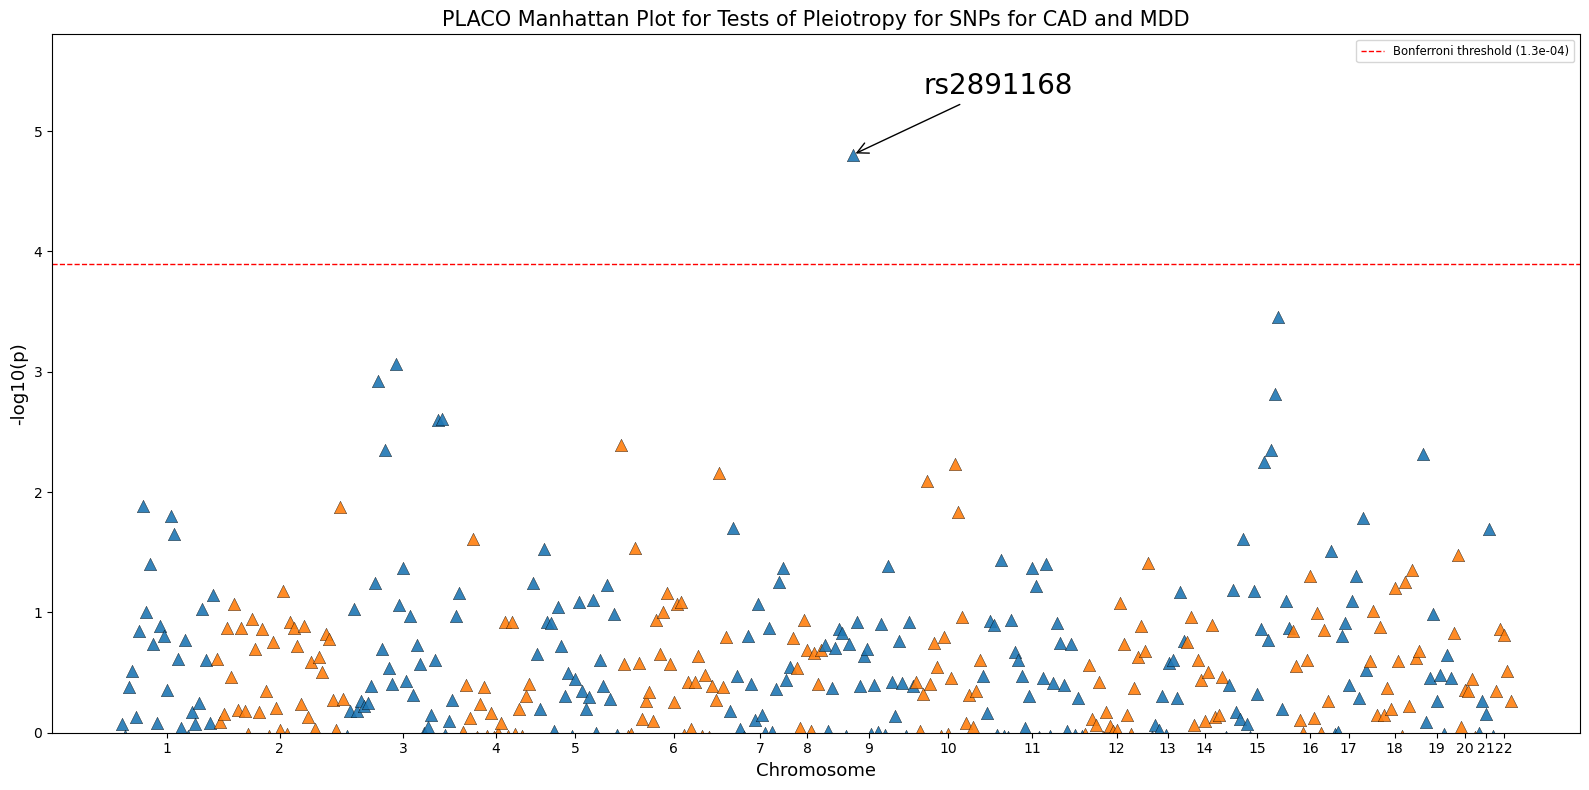

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Read the CSV
df = pd.read_csv("PLACO_output.csv")

# Step 2: Calculate significance level
alpha = 0.05
num_rows = len(df)
significance_level = alpha / num_rows
threshold_line = -np.log10(significance_level)

# Step 3: Prepare the data
df['-log10(p)'] = -np.log10(df['p.placo'])
df['CHR'] = df['CHR'].astype(str)
df['CHR'] = df['CHR'].astype('category')
df['CHR'] = df['CHR'].cat.set_categories(
    sorted(df['CHR'].unique(), key=lambda x: int(x)),
    ordered=True
)
df = df.sort_values(['CHR', 'BP'])

# Step 4: Create chromosome-specific index for plotting
df['ind'] = range(len(df))
df_grouped = df.groupby('CHR')

# Define two contrasting colors to alternate
colors = ['#1f77b4', '#ff7f0e']  # blue & orange

# Step 5: Plot
plt.figure(figsize=(16, 8))

x_labels = []
x_labels_pos = []

for i, (chr_name, group) in enumerate(df_grouped):
    plt.scatter(
        group['ind'], group['-log10(p)'],
        color=colors[i % 2],
        s=80,                       
        marker='^',
        alpha=0.9,
        edgecolor='black',
        linewidth=0.3,
        label=None
    )
    x_labels.append(chr_name)
    x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)

# Add genome-wide significance threshold line
plt.axhline(
    y=threshold_line,
    color='red',
    linestyle='--',
    linewidth=1,
    label=f'Bonferroni threshold ({significance_level:.1e})'
)

# Final plot adjustments before annotation
plt.xticks(x_labels_pos, x_labels, rotation=0, fontsize=10)
plt.xlabel('Chromosome', fontsize=13)
plt.ylabel('-log10(p)', fontsize=13)
plt.title('PLACO Manhattan Plot for Tests of Pleiotropy for SNPs for CAD and MDD', fontsize=15)

# Determine y-limit and adjust it if necessary
y_max = df['-log10(p)'].max() + 1
plt.ylim(0, y_max)

# Annotate the significant SNP `rs2891168`
if 'SNP' in df.columns:
    sig_snp = df.loc[(df['SNP'] == 'rs2891168') & (df['-log10(p)'] >= threshold_line)]
    if not sig_snp.empty:
        x = sig_snp['ind'].values[0]
        y = sig_snp['-log10(p)'].values[0]
        # keep the label below the plot top
        y_text = min(y + 0.5, y_max - 0.5)
        plt.annotate(
            'rs2891168',
            xy=(x, y),
            xytext=(x+20, y_text),
            arrowprops=dict(arrowstyle='->', color='black', lw=1),
            fontsize=20,
            color='black',
            ha='left'
        )

plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()

# Save & show
plt.savefig("PLACO_manhattan_triangles_annotated_fixed.jpeg", dpi=300)
plt.show()


In [14]:
'''
df[df["p.placo"] < alpha / num_rows]
df1_subset[df1_subset["SNP"]=="rs2891168"]
df2_subset[df2_subset["SNP"]=="rs2891168"]
df1_subset[df1_subset["SNP"]=="rs2071382"]
df2_subset[df2_subset["SNP"]=="rs2071382"]
df1[df1["SNP"]=="rs17514846"]
df1_subset[df1_subset["SNP"]=="rs4295278"]
df2_subset[df2_subset["SNP"]=="rs4295278"]
'''

'\ndf[df["p.placo"] < alpha / num_rows]\ndf1_subset[df1_subset["SNP"]=="rs2891168"]\ndf2_subset[df2_subset["SNP"]=="rs2891168"]\ndf1_subset[df1_subset["SNP"]=="rs2071382"]\ndf2_subset[df2_subset["SNP"]=="rs2071382"]\ndf1[df1["SNP"]=="rs17514846"]\ndf1_subset[df1_subset["SNP"]=="rs4295278"]\ndf2_subset[df2_subset["SNP"]=="rs4295278"]\n'

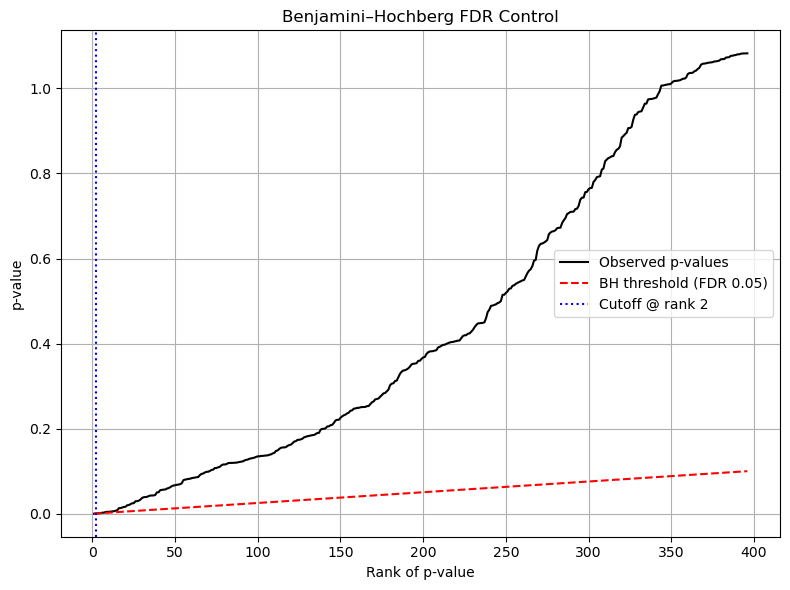

In [22]:
## FDR by BH Method

import numpy as np
import matplotlib.pyplot as plt

# Example: Assume your DataFrame is called placo_df and has a column 'p_placo'
p_vals = df['p.placo'].dropna().values
n = len(p_vals)

# Step 1: Sort p-values and compute BH threshold
sorted_indices = np.argsort(p_vals)
sorted_pvals = p_vals[sorted_indices]
rank = np.arange(1, n + 1)
bh_threshold = (rank / n) * 0.1  # FDR level = 0.05

# Step 2: Find the largest p-value below its threshold
below_threshold = sorted_pvals <= bh_threshold
cutoff_index = np.where(below_threshold)[0].max() if np.any(below_threshold) else None

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(rank, sorted_pvals, label="Observed p-values", color="black")
plt.plot(rank, bh_threshold, label="BH threshold (FDR 0.05)", color="red", linestyle="--")

if cutoff_index is not None:
    plt.axvline(x=cutoff_index + 1, color="blue", linestyle=":", 
                label=f"Cutoff @ rank {cutoff_index + 1}")

plt.xlabel("Rank of p-value")
plt.ylabel("p-value")
plt.title("Benjamini–Hochberg FDR Control")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("BH_0.1.jpeg")
plt.show()


In [38]:
p_vals = df['p.placo'].dropna().values
n = len(p_vals)

# Step 1: Sort p-values and compute BH threshold
sorted_indices = np.argsort(p_vals)
sorted_pvals = p_vals[sorted_indices]
df.iloc[sorted_indices]

,CHR,SNP,BP,T.placo,p.placo
199,9,rs2891168,22098619,41.083063,0.000016
163,15,rs2071382,91428197,-29.063939,0.000349
234,3,rs4283605,49678651,25.623992,0.000862
202,3,rs3172494,48731487,24.396128,0.001195
253,15,rs4702,91426560,-23.490254,0.001521
...,...,...,...,...,...
23,11,rs10835549,29646947,-0.335605,1.081549
121,6,rs16891156,160608804,0.260771,1.082169
182,15,rs2412546,41006523,-0.300487,1.082438
235,4,rs4295278,123547541,-0.296860,1.082473
